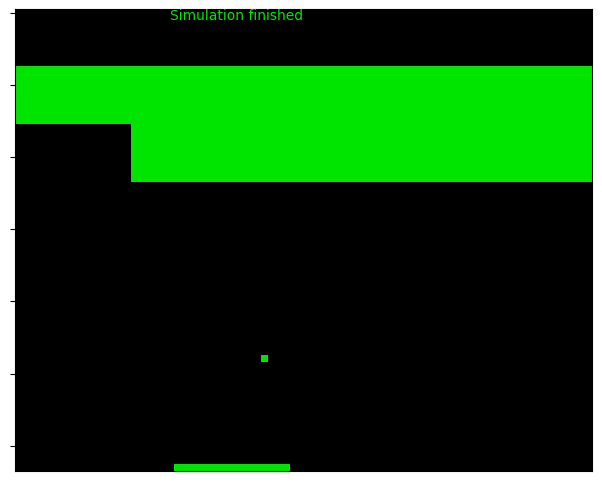

In [1]:
import spynnaker8 as p
from spinn_gym.games.breakout.visualise_jupyter import jupyter_visualiser
from spinn_gym.games.breakout.automated_breakout import (
    AutomatedBreakout, X_RES, X_SCALE, Y_RES, Y_SCALE)

# ----------------------------------------------------------------------------------------------------------------------
# Initialise Simulation and Parameters
# ----------------------------------------------------------------------------------------------------------------------
breakout = AutomatedBreakout()

# ----------------------------------------------------------------------------------------------------------------------
# Configure Visualiser
# ----------------------------------------------------------------------------------------------------------------------
jupyter_visualiser(breakout, X_RES, X_SCALE, Y_RES, Y_SCALE)

In [2]:
# ----------------------------------------------------------------------------------------------------------------------
# Run Simulation
# ----------------------------------------------------------------------------------------------------------------------
runtime = 1000 * 120
print("\nLet\'s play breakout!")
p.run(runtime)
p.end()
print("Simulation Complete")

2022-04-28 11:19:01 WARNING: File spynnaker8 moved to pyNN.spinnaker which points to spynnaker.pyNN. Please fix your imports. In version 8 this will fail completely.
2022-04-28 11:19:01 INFO: Starting execution process
2022-04-28 11:19:01 INFO: Simulating for 120000 1.0ms timesteps using a hardware timestep of 1000.0us



Let's play breakout!


2022-04-28 11:19:04 INFO: Spalloc max machine generator took 0:00:03.157514 
2022-04-28 11:19:04 INFO: SpYNNakerNeuronGraphNetworkSpecificationReport skipped as cfg Reports:write_network_graph is False
2022-04-28 11:19:04 INFO: Network Specification report took 0:00:00.000435 
2022-04-28 11:19:04 INFO: Splitter reset took 0:00:00.000014 
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2022-04-28 11:19:04 INFO: Spynnaker splitter selector took 0:00:00.011366 
2022-04-28 11:19:04 INFO: Preallocate for live packet gatherer took 0:00:00.000073 
2022-04-28 11:19:04 INFO: Preallocate for chip power monitor skipped as cfg Reports:write_energy_report is False
2022-04-28 11:19:04 INFO: Preallocate for extra monitor support took 0:00:00.000075 
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
 ========/home/bb

Visualiser closed


2022-04-28 11:21:55 INFO: Extract IO buff took 0:00:00.328285 
Extracting buffers from the last run
|0%                          50%                         100%|

2022-04-28 11:21:56 INFO: Buffer extractor took 0:00:01.135558 
clearing IOBUF from the machine
|0%                          50%                         100%|
2022-04-28 11:21:56 INFO: Clear IO buffer took 0:00:00.013612 
Getting provenance data from machine graph
|0%                          50%                         100%|
Getting provenance data from application graph
|0%                          50%                         100%|
2022-04-28 11:21:56 INFO: Graph provenance gatherer took 0:00:00.142308 
Getting provenance data
|0%                          50%                         100%|
2022-04-28 11:21:57 INFO: Placements provenance gatherer took 0:00:00.285429 
Getting Router Provenance
|0%                          50%                         100%|
2022-04-28 11:21:57 INFO: Router provenance gatherer took 0:00:00.21617

Simulation Complete
